In [1]:
# !curl -o hello.zip https://p5awqg.bn.files.1drv.com/y4mA-IEUekCe26UIJgz2ProYp4zvREkBRgWqgnpQ-CG1ogbzKqNUbf_okXphIRbqldqeOqjSn0jwkvV5LSbzBMylwoFNyA4tujk9iuT3QMASbP_BFRNbw4sE1AuDtduNKpuImWahZ9--9kftzW27Dryb3wqoc6ba4_KZwgBe75nCNekCKIYV4-vUXiUBEffjfIccX6vuipt7_iy2SStMBAIgw

In [2]:
# !pip3 install transformers datasets evaluate

In [1]:
import os
from collections import Counter
from statistics import median
from pprint import pprint
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import nltk
from nltk import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')

import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW, Adam

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import evaluate

print(f'Pytorch version: {torch.__version__}')

# device='cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print(f'Device: {torch.cuda.get_device_name(torch.cuda.current_device())}')

RANDOM_SEED = 42

/home/dhairya/projects/sih/ml_components/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/dhairya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-09-21 21:02:20.777538: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 21:02:21.565050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the 

Pytorch version: 2.0.1+cu117
Device: NVIDIA GeForce MX350


In [4]:
# !unzip hello.zip

In [5]:
# !unzip ILDC_single/ILDC_single.csv.zip

In [48]:
class Config():
    def __init__(self, filePath: str, baseModelName: str):
        self.filePath = filePath
        # self.MAX_TOKENS = 16384
        self.MAX_TOKENS = 1024
        self.BATCH_SIZE = 1
        self.baseModelName = baseModelName
        self.EPOCHS = 5
        self.tokenizer = AutoTokenizer.from_pretrained(baseModelName)

# config = Config('./ILDC_single.csv',
#                 'hyperonym/xlm-roberta-longformer-base-16384')
# config = Config('./ILDC_single.csv',
#                 'allenai/longformer-base-4096')

In [49]:
filePath = os.path.join('..', 'data', 'ILDC_single', 'ILDC_single.csv')
config = Config(filePath,
                'facebook/bart-base')

In [50]:
print(f'Unknown token: {config.tokenizer.unk_token}, ID: {config.tokenizer.unk_token_id}')
print(f'Seperator token: {config.tokenizer.sep_token}, ID: {config.tokenizer.sep_token_id}')
print(f'Padding token: {config.tokenizer.pad_token}, ID: {config.tokenizer.pad_token_id}')
print(f'mask token: {config.tokenizer.mask_token}, ID: {config.tokenizer.mask_token_id}')
print(f'Sentence level classification token: {config.tokenizer.cls_token}, ID: {config.tokenizer.cls_token_id}')

Unknown token: <unk>, ID: 3
Seperator token: </s>, ID: 2
Padding token: <pad>, ID: 1
mask token: <mask>, ID: 50264
Sentence level classification token: <s>, ID: 0


In [51]:
data = pd.read_csv(config.filePath)
data.head()

,text,label,split,name
0,"F. NARIMAN, J. Leave granted. In 2008, the Pu...",1,train,2019_890.txt
1,"S. THAKUR, J. Leave granted. These appeals ar...",0,train,2014_170.txt
2,"Markandey Katju, J. Leave granted. Heard lear...",1,train,2010_721.txt
3,"ALTAMAS KABIR,J. Leave granted. The question ...",1,train,2008_1460.txt
4,"CIVIL APPEAL NO. 598 OF 2007 K. MATHUR, J. Th...",1,train,2008_188.txt


In [52]:
# data split percentages
data_s = Counter(data['split'])
num_rows = sum(data_s.values())
[float(f'{val/num_rows:.2f}') for val in data_s.values()]

[0.67, 0.2, 0.13]

In [53]:
train_ds = data[data['split'] == 'train'].drop(['split', 'name'], axis=1)
dev_ds = data[data['split'] == 'dev'].drop(['split', 'name'], axis=1)
test_ds = data[data['split'] == 'test'].drop(['split', 'name'], axis=1)

train_ds = train_ds.reset_index(drop=True)
dev_ds = dev_ds.reset_index(drop=True)
test_ds = test_ds.reset_index(drop=True)

del data

print(Counter(train_ds['label']))
print(Counter(dev_ds['label']))
print(Counter(test_ds['label']))

Counter({0: 3147, 1: 1935})
Counter({0: 497, 1: 497})
Counter({1: 762, 0: 755})


In [54]:
import string

class LegalDataset(Dataset):
    def __init__(self, texts, labels) -> None:
        super(LegalDataset, self).__init__()
        self.texts = texts
        self.labels = labels
        self.lemmatizer = WordNetLemmatizer()
        self.porter = PorterStemmer()

    def __preprocess_text(self, data: str) -> str:
        text: str = data.strip()
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = self.lemmatizer.lemmatize(text, 'v')
        text = self.porter.stem(text)
        return text

    def __len__(self) -> int: return len(self.texts)

    def __getitem__(self, ix):
        text = self.texts[ix]
        text = self.__preprocess_text(text)
        label = torch.tensor(self.labels[ix], dtype=torch.float16)

        inputs = config.tokenizer(
            text=text,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            max_length=config.MAX_TOKENS,
            return_tensors='pt'
        )

        inputs = {k: v[0] for k, v in inputs.items()}
        inputs['labels'] = label.type(torch.float32)
        return inputs


In [55]:
hg_train_ds = LegalDataset(texts=train_ds.loc[:, 'text'], labels=train_ds.loc[:, 'label'])
hg_dev_ds = LegalDataset(texts=dev_ds.loc[:, 'text'], labels=dev_ds.loc[:, 'label'])

train_loader = DataLoader(hg_train_ds, batch_size=config.BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(hg_dev_ds, batch_size=config.BATCH_SIZE)

In [56]:
del train_ds
del dev_ds

In [57]:
batch = next(iter(train_loader))
{k:v for k, v in batch.items()}

{'input_ids': tensor([[    0,   298, 21746,  ...,    21,  1658,     2]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]]),
 'labels': tensor([0.])}

In [58]:
batch = next(iter(dev_loader))
{k:v for k, v in batch.items()}

{'input_ids': tensor([[    0, 37635, 28500,  ...,  1132,     9,     2]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]]),
 'labels': tensor([0.])}

In [82]:
# model = AutoModelForSequenceClassification\
#         .from_pretrained(config.baseModelName, from_tf=True, num_labels=1)
model = AutoModelForSequenceClassification\
        .from_pretrained(config.baseModelName, num_labels=1)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

0
0


In [18]:
optimizer = Adam(params=model.parameters(), lr=3e-2)
TRAIN_STEPS = len(train_loader) * config.BATCH_SIZE

# lr_scheduler = get_scheduler(
#     name='linear',
#     optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=TRAIN_STEPS
# )

In [19]:
CUDA_LAUNCH_BLOCKING=1

In [20]:
if device == 'cuda': torch.cuda.empty_cache()

In [44]:
class Trainer:
    def __init__(self, epochs: int) -> None:
        self.device = torch.device(
            "cuda" if torch.has_cuda else "mps" if torch.has_mps else "cpu"
        )
#         self.device = 'cpu'
        self.epochs = epochs
        self.model = model.to(self.device)
        self.optimizer = Adam(model.parameters(), lr=3e-2)

        num_train_steps = len(train_loader) * config.BATCH_SIZE

        self.scheduler = get_scheduler(
            name='linear',
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=num_train_steps
        )

        self.train_loader = None
        self.valid_loader = None

        self.best_model = {'loss': np.inf, 'weights': None}

        self.history = {
            'epoch': [],
            'train_loss': [],
            'valid_loss': []
        }


    def train_one_step(self, batch):
        for k, v in batch.items():
            batch[k] = v.to(self.device)
            
        output = self.model.forward(**batch)
        loss, yhat = output['loss'], output['logits']

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        return loss


    def train_one_epoch(self, data_loader):
        self.model.train()
        epoch_loss = 0.0
        for batch in tqdm(self.train_loader):
            loss = self.train_one_step(batch)
            epoch_loss += loss
        print('training done')
        return epoch_loss / len(self.train_loader)


    def validate(self, data_loader):
        self.model.eval()
        total_loss = 0.0
        with torch.inference_mode():
            for batch in data_loader:
                for k, v in batch.items():
                    batch[k] = v.to(self.device)

                output = self.model.forward(**batch)
                loss, yhat = output['loss'], output['logits']
                total_loss += loss

        print('validation done')

        return total_loss / len(data_loader)


    def predict(self, input_ids: torch.Tensor,
                token_type_ids: torch.Tensor,
                attention_mask: torch.Tensor) -> np.ndarray:
        yHat, _ = self.model.forward(input_ids=input_ids.to(self.device),
                                     token_type_ids=token_type_ids.to(self.device),
                                     attention_mask=attention_mask.to(self.device))
        return yHat.detach().cpu().numpy()


    def fit(self, train_loader: DataLoader, valid_loader: Optional[DataLoader] = None) -> None:

        if self.train_loader is None and train_loader is None:
            raise Exception("Train Loader cannot be None.")

        self.train_loader = train_loader
        self.valid_loader = valid_loader

        for epoch in range(self.epochs):
            print(f'Training on Epoch #[{epoch + 1}/{self.epochs}]')

            train_loss = self.train_one_epoch(self.train_loader)
            valid_loss = None
            if self.valid_loader:
                valid_loss = self.validate(self.valid_loader)

            self.history['epoch'].append(epoch)
            self.history['train_loss'].append(train_loss)
            self.history['valid_loss'].append(valid_loss)

            if valid_loss < self.best_model['loss']:
                self.best_model['loss'] = valid_loss
                self.best_model['weights'] = self.model.state_dict()

            torch.save(self.model, f'model_{epoch}.pth')

            print(f"Epoch[{epoch+1}/{self.epochs}]train_loss: {self.history['train_loss'][-1]}\t valid_loss: {self.history['valid_loss'][-1]}", end='\r')

In [22]:
trainer = Trainer(epochs=config.EPOCHS)
trainer.fit(train_loader=train_loader, valid_loader=dev_loader)

Training on Epoch #[1/5]


  0%|          | 0/2541 [00:00<?, ?it/s]

/home/ex5/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


training done
validation done
Training on Epoch #[2/5]148418664932251	 valid_loss: 1.0150532722473145


  0%|          | 0/2541 [00:00<?, ?it/s]

training done
validation done
Training on Epoch #[3/5]9620331525802612	 valid_loss: 0.25012072920799255


  0%|          | 0/2541 [00:00<?, ?it/s]

training done
validation done
Training on Epoch #[4/5]801478385925293	 valid_loss: 5.007641315460205


  0%|          | 0/2541 [00:00<?, ?it/s]

training done
validation done
Training on Epoch #[5/5]7950743436813354	 valid_loss: 2.519602060317993


  0%|          | 0/2541 [00:00<?, ?it/s]

training done
validation done


In [33]:
train_hist = [loss.cpu().detach().numpy() for loss in trainer.history['train_loss']]
dev_hist = [loss.cpu().detach().numpy() for loss in trainer.history['valid_loss']]

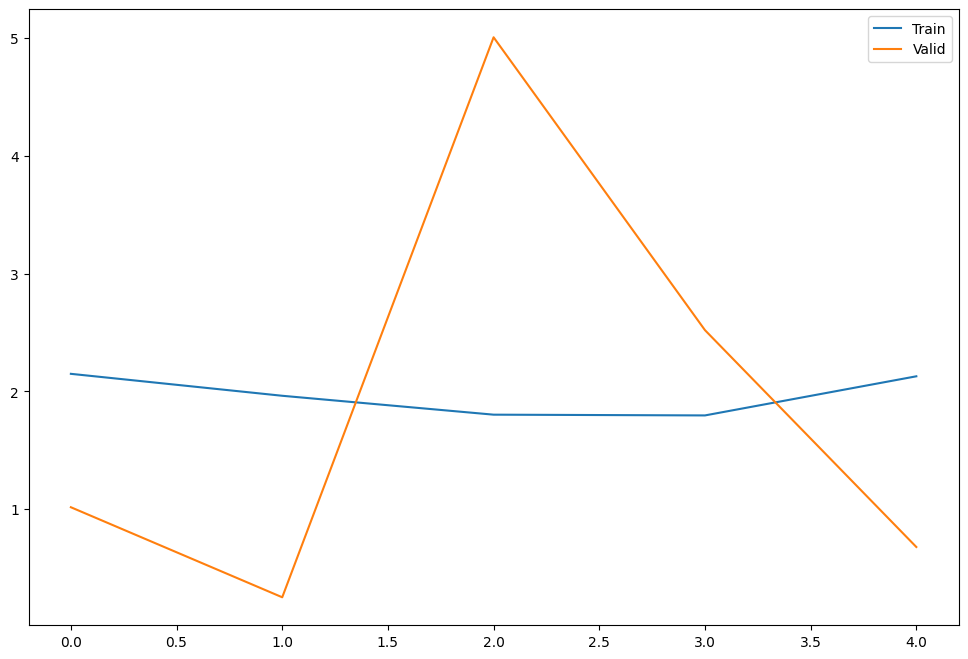

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(trainer.history['epoch'], train_hist, label='Train')
plt.plot(trainer.history['epoch'], dev_hist, label='Valid')
plt.legend()
plt.show()

In [84]:
torch.save(trainer.best_model['weights'], 'best_model.pth')

In [85]:
xmodel = AutoModelForSequenceClassification\
        .from_pretrained(config.baseModelName, num_labels=1)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
xmodel.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [60]:
hg_test_ds = LegalDataset(texts=test_ds.loc[:, 'text'], labels=test_ds.loc[:, 'label'])
test_loader = DataLoader(hg_test_ds, batch_size=config.BATCH_SIZE, shuffle=False)

In [61]:
hg_test_ds[0]

{'input_ids': tensor([    0, 37635, 28500,  ...,  8953,     9,     2]),
 'attention_mask': tensor([1, 1, 1,  ..., 1, 1, 1]),
 'labels': tensor(1.)}

In [62]:
batch = next(iter(test_loader))
{k: v for k, v in batch.items()}

{'input_ids': tensor([[    0, 37635, 28500,  ...,  8953,     9,     2]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]]),
 'labels': tensor([1.])}

In [85]:
def accEval(y, yhat):
    yhat = torch.sigmoid(yhat)
    for i in range(len(yhat)):
        yhat[i] = 0 if yhat[i] < 0.25 else 1
    tp = 0
    
    for i in range(len(yhat)):
        if yhat[i] == y[i]: tp +=1
    
    return tp

In [87]:
total_loss = 0.0
probs = []
with torch.inference_mode():
    tp = 0
    minyhat = 1
    maxyhat = 0
    for batch in tqdm(test_loader):
        for k, v in batch.items(): 
            batch[k] = v


        output = model(**batch)
        loss, yhat = output['loss'], output['logits']
        total_loss += loss
        minyhat = min(minyhat, yhat)
        maxyhat = max(maxyhat, yhat)
        probs.append(torch.sigmoid(yhat))
        yhatk = 0 if torch.sigmoid(yhat) < 0.45 else 1
        # print(torch.sigmoid(yhat), batch['labels'].unsqueeze(dim=1))
        
        y = batch['labels'].unsqueeze(dim=1)
        
        tp += accEval(y, yhat)

print(tp/(len(test_loader)))
print(total_loss / len(test_loader))

100%|██████████| 1517/1517 [46:02<00:00,  1.82s/it]


0.5023071852340145
tensor(0.8317)


In [81]:
torch.save(model.state_dict(), 'server/model/BART_best.pth')

In [84]:
model.load_state_dict(torch.load('server/model/BART_best.pth'))

<All keys matched successfully>

In [89]:
minyhat, maxyhat

(tensor([[-0.9105]]), tensor([[0.5328]]))

In [88]:
(minyhat + maxyhat)/2

tensor([[-0.1888]])

In [90]:
print(tp / (len(test_loader)))

0.5023071852340145


In [97]:
a = torch.tensor([[0.7418]]).squeeze()
float(a)

0.7418000102043152